# 1. Import Library

In [ ]:
!pip install protobuf==3.20.1

In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re
import shutil

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers import Normalization
from keras.models import Model, Sequential
# from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.layers import Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

2025-12-27 07:06:15.099076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766819175.262131      87 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766819175.311247      87 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Preprocessing Data

In [2]:
import os
import shutil

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32

# --- 1. Konfigurasi Awal (Silakan Sesuaikan) ---

# Tentukan path ke folder 12 kelas Anda
# (Ini adalah folder yang berisi 12 sub-folder seperti 'kaca', 'plastik', 'daun', dll.)
SOURCE_DIR = '/kaggle/input/garbage-classification/garbage_classification' 

# Tentukan nama untuk folder dataset 2 kelas yang baru
DEST_DIR = '/kaggle/working/garbage-organik-anorganik'

MAPPING = {
    # --- Kelas Anorganik ---
    'battery': 'anorganik',
    'brown-glass': 'anorganik',
    'clothes': 'anorganik',
    'green-glass': 'anorganik',
    'metal': 'anorganik',
    'plastic': 'anorganik',
    'shoes' : 'anorganik',
    'trash' : 'anorganik',
    'white-glass' : 'anorganik',
    
    # --- Kelas Organik ---
    'biological': 'organik',
    'cardboard': 'organik',
    'paper': 'organik'
}

# --- 2. Proses Pembuatan Folder Baru ---
print(f"Membuat direktori baru di: {DEST_DIR}")

# Buat folder utama (jika belum ada)
os.makedirs(DEST_DIR, exist_ok=True)

# Buat 2 folder kelas baru di dalamnya
new_class_names = ['organik', 'anorganik']
for class_name in new_class_names:
    os.makedirs(os.path.join(DEST_DIR, class_name), exist_ok=True)

print("Direktori baru 'organik' dan 'anorganik' telah dibuat.\n")

# --- 3. Proses Penyalinan dan Pengelompokan Ulang ---

print("Memulai proses penyalinan dan pengelompokan ulang gambar...")
total_files_copied = 0

# Loop melalui setiap item di kamus MAPPING
for old_class, new_class in MAPPING.items():
    
    old_folder_path = os.path.join(SOURCE_DIR, old_class)
    new_folder_path = os.path.join(DEST_DIR, new_class)
    
    # Periksa apakah folder kelas lama ada
    if not os.path.isdir(old_folder_path):
        print(f"PERINGATAN: Folder '{old_class}' tidak ditemukan. Dilewati.")
        continue
        
    print(f"\nMemproses folder: '{old_class}'  ==>  Menyalin ke '{new_class}'")
    
    file_count = 0
    # Loop melalui setiap gambar di folder kelas lama
    for filename in os.listdir(old_folder_path):
        # Path file sumber
        source_file = os.path.join(old_folder_path, filename)
        
        # Buat nama file baru untuk mencegah file tumpang tindih
        # Contoh: 'kaca_001.jpg', 'plastik_001.jpg'
        new_filename = f"{old_class}_{filename}"
        
        # Path file tujuan
        dest_file = os.path.join(new_folder_path, new_filename)
        
        # Salin file (shutil.copy2 juga menyalin metadata file)
        if os.path.isfile(source_file):
            shutil.copy2(source_file, dest_file)
            file_count += 1
            total_files_copied += 1
            
    print(f"Selesai: Menyalin {file_count} gambar dari '{old_class}'.")

print(f"\n--- PROSES SELESAI ---")
print(f"Total {total_files_copied} gambar telah disalin ke folder '{DEST_DIR}'.")

Membuat direktori baru di: /kaggle/working/garbage-organik-anorganik
Direktori baru 'organik' dan 'anorganik' telah dibuat.

Memulai proses penyalinan dan pengelompokan ulang gambar...

Memproses folder: 'battery'  ==>  Menyalin ke 'anorganik'
Selesai: Menyalin 945 gambar dari 'battery'.

Memproses folder: 'brown-glass'  ==>  Menyalin ke 'anorganik'
Selesai: Menyalin 607 gambar dari 'brown-glass'.

Memproses folder: 'clothes'  ==>  Menyalin ke 'anorganik'
Selesai: Menyalin 5325 gambar dari 'clothes'.

Memproses folder: 'green-glass'  ==>  Menyalin ke 'anorganik'
Selesai: Menyalin 629 gambar dari 'green-glass'.

Memproses folder: 'metal'  ==>  Menyalin ke 'anorganik'
Selesai: Menyalin 769 gambar dari 'metal'.

Memproses folder: 'plastic'  ==>  Menyalin ke 'anorganik'
Selesai: Menyalin 865 gambar dari 'plastic'.

Memproses folder: 'shoes'  ==>  Menyalin ke 'anorganik'
Selesai: Menyalin 1977 gambar dari 'shoes'.

Memproses folder: 'trash'  ==>  Menyalin ke 'anorganik'
Selesai: Menyalin 69

In [3]:
import os
import pandas as pd

# 1. Tentukan path data Anda
# (Sesuaikan 'dataset_12_kelas/' jika namanya berbeda)
data_dir = '/kaggle/working/garbage-organik-anorganik'

# 2. Deteksi otomatis semua folder (kategori) di dalam data_dir
try:
    categories = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
except FileNotFoundError:
    print(f"Error: Direktori '{data_dir}' tidak ditemukan. Silakan sesuaikan path.")
    categories = []

print(f"Ditemukan {len(categories)} kelas: {categories}\n")

# --- Kode Anda (dengan sedikit modifikasi) ---
filenames_list = []
categories_list = []
filepaths_list = [] # Kita tambahkan ini untuk menyimpan path lengkap

# Loop untuk mengumpulkan semua data
for category_name in categories:
    folder_path = os.path.join(data_dir, category_name)
    filenames = os.listdir(folder_path)
    
    for f in filenames:
        # Simpan path lengkap, nama file, dan kategori
        filepaths_list.append(os.path.join(folder_path, f))
        filenames_list.append(f)
        categories_list.append(category_name)

# Buat DataFrame
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list,
    'filepath': filepaths_list  # <--- Path lengkapnya disimpan di sini
})

# Acak (Shuffle) DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f'Jumlah total data: {len(df)}')

Ditemukan 2 kelas: ['organik', 'anorganik']

Jumlah total data: 15515


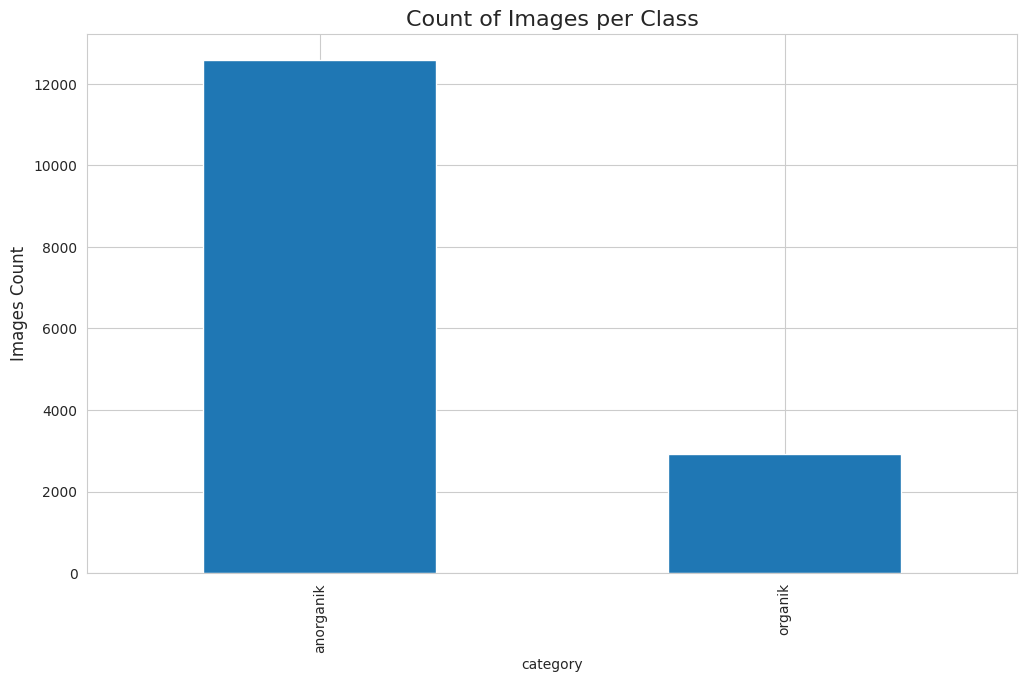

In [4]:
# Atur style plot agar lebih menarik
sns.set_style('whitegrid')

# Buat figure dan axes untuk plot
plt.figure(figsize=(12, 7))

# Hitung jumlah data untuk setiap kategori dan buat bar plot
# .value_counts() akan menghitung jumlah baris untuk setiap 'category'
# .plot(kind='bar') akan membuat bar chart dari hasil perhitungan tersebut
df['category'].value_counts().plot(kind='bar')

# Tambahkan judul dan label pada sumbu
plt.title('Count of Images per Class', fontsize=16)
plt.ylabel('Images Count', fontsize=12)
plt.xticks(rotation=90)

# Tampilkan plotnya
plt.show()

## split data

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# (Asumsi 'df' dan 'data_dir' sudah ada dari kode sebelumnya)
# df['filepath'] berisi path lengkap seperti 'dataset_12_kelas/kaca/img_001.jpg'

# 1. bagi data train 80% dan test 20%
print("Membagi daftar file (DataFrame)...")
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['category']
)

print(f"Data latih: {len(train_df)} | Data uji: {len(test_df)}")

# 2. Tentukan direktori tujuan
# (Kita tidak perlu 'source_dir' lagi di sini)
train_dest_dir = "/kaggle/working/train/"
test_dest_dir = "/kaggle/working/test/"

# --- (OPSIONAL) Membersihkan folder tujuan jika sudah ada ---
if os.path.exists(train_dest_dir):
    shutil.rmtree(train_dest_dir)
if os.path.exists(test_dest_dir):
    shutil.rmtree(test_dest_dir)
print(f"Folder tujuan '{train_dest_dir}' dan '{test_dest_dir}' telah disiapkan.")

# 3. Buat fungsi untuk menyalin file (SUDAH DIPERBAIKI)
def copy_files(dataframe, destination):  # <-- Hapus parameter 'source'
    for index, row in dataframe.iterrows():
        # Buat path folder kategori di tujuan (misal: /kaggle/working/train/kaca/)
        category_folder = os.path.join(destination, row['category'])
        os.makedirs(category_folder, exist_ok=True)
        
        # --- INI BAGIAN YANG DIPERBAIKI ---
        # 'row['filepath']' sudah berisi path sumber yang lengkap
        source_file_path = row['filepath'] 
        
        destination_file_path = os.path.join(category_folder, row['filename'])
        
        # Salin file
        if os.path.exists(source_file_path):
            shutil.copy(source_file_path, destination_file_path)

# 4. Jalankan fungsi untuk menyalin data latih dan uji
print(f"\nMenyalin {len(train_df)} gambar ke direktori '{train_dest_dir}'...")
copy_files(train_df, train_dest_dir) # <-- Hapus parameter 'source_dir'

print(f"Menyalin {len(test_df)} gambar ke direktori '{test_dest_dir}'...")
copy_files(test_df, test_dest_dir) # <-- Hapus parameter 'source_dir'

print("\nProses penyalinan selesai! ✅")

Membagi daftar file (DataFrame)...
Data latih: 12412 | Data uji: 3103
Folder tujuan '/kaggle/working/train/' dan '/kaggle/working/test/' telah disiapkan.

Menyalin 12412 gambar ke direktori '/kaggle/working/train/'...
Menyalin 3103 gambar ke direktori '/kaggle/working/test/'...

Proses penyalinan selesai! ✅


## menampilkan train dan test

In [6]:
# 1. Tentukan path ke direktori latih dan uji
train_dir = "/kaggle/working/train/"
test_dir = "/kaggle/working/test/"

print(f"Menganalisis isi direktori '{train_dir}' dan '{test_dir}'...\n")

# 2. Dapatkan daftar nama kelas (nama subfolder) dari direktori latih
# Menggunakan sorted() agar urutannya konsisten
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

print(f"Total kelas yang ditemukan: {num_classes}\n")

# 3. Siapkan list untuk menampung jumlah gambar per kelas
train_counts = []
test_counts = []

# 4. Loop melalui setiap kelas untuk menghitung jumlah file
for category in class_names:
    # Hitung jumlah file di folder train untuk kategori ini
    train_category_path = os.path.join(train_dir, category)
    train_counts.append(len(os.listdir(train_category_path)))
    
    # Hitung jumlah file di folder test untuk kategori ini
    test_category_path = os.path.join(test_dir, category)
    # Gunakan blok try-except untuk menangani jika ada folder yang kosong atau tidak ada
    try:
        test_counts.append(len(os.listdir(test_category_path)))
    except FileNotFoundError:
        test_counts.append(0)

# 5. Buat DataFrame untuk menampilkan ringkasan 📊
summary_df = pd.DataFrame({
    'Kategori': class_names,
    'Jumlah Latih (Train)': train_counts,
    'Jumlah Uji (Test)': test_counts
})

# Tambahkan baris total untuk verifikasi
total_row = pd.DataFrame({
    'Kategori': ['TOTAL'],
    'Jumlah Latih (Train)': [summary_df['Jumlah Latih (Train)'].sum()],
    'Jumlah Uji (Test)': [summary_df['Jumlah Uji (Test)'].sum()]
})

# Gabungkan DataFrame utama dengan baris total
summary_df = pd.concat([summary_df, total_row], ignore_index=True)


# Tampilkan tabel ringkasan
print("--- Ringkasan Jumlah Gambar per Kelas ---")
print(summary_df.to_string())

Menganalisis isi direktori '/kaggle/working/train/' dan '/kaggle/working/test/'...

Total kelas yang ditemukan: 2

--- Ringkasan Jumlah Gambar per Kelas ---
    Kategori  Jumlah Latih (Train)  Jumlah Uji (Test)
0  anorganik                 10071               2518
1    organik                  2341                585
2      TOTAL                 12412               3103


## menangani imbalance data

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Definisikan indeks kelas baru Anda (0 dan 1)
# Misal: 0 = anorganik, 1 = organik
# (Anda bisa cek urutan ini dari output train_generator.class_indices)
class_indices = np.array([0, 1])
train_counts = np.array([
    10071,  # 0: anorganik (CONTOH)
    2341   # 1: organik (CONTOH)
])

# 3. Buat array 'y' tiruan yang merepresentasikan semua label di data train
y_train_dummy = []
for idx, count in zip(class_indices, train_counts):
    y_train_dummy.extend([idx] * count)

# 4. Hitung class weights menggunakan sklearn
# 'balanced' akan otomatis menghitung bobot
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=class_indices,
    y=y_train_dummy
)

# 5. Ubah menjadi format dictionary yang dibutuhkan oleh Keras
# Keras memerlukan format: {class_index: weight}
class_weights = dict(zip(class_indices, class_weights_array))

print("--- Class Weights yang akan Digunakan ---")
print(class_weights)
print("-------------------------------------------")

--- Class Weights yang akan Digunakan ---
{0: 0.6162248038923642, 1: 2.651003844510893}
-------------------------------------------


## normalisasi dan scaller data

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# --- 1. Tentukan Parameter ---

# Ukuran gambar yang Anda inginkan (sesuaikan dengan model CNN Anda)
# Semua gambar akan di-resize ke ukuran ini.
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Berapa banyak gambar yang diproses sekaligus (batch)
BATCH_SIZE = 32

# Path ke folder data Anda
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

# --- 2. Buat "Data Generator" ---

# Untuk data TRAINING:
# Kita lakukan normalisasi (rescale) dan augmentasi data
# Augmentasi (seperti rotasi, zoom) membantu model agar tidak overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,      # Augmentasi: rotasi gambar
    width_shift_range=0.2,  # Augmentasi: geser horizontal
    height_shift_range=0.2, # Augmentasi: geser vertical
    shear_range=0.2,        # Augmentasi: "miringkan" gambar
    zoom_range=0.2,         # Augmentasi: zoom gambar
    horizontal_flip=True,   # Augmentasi: balik horizontal
    fill_mode='nearest'     # Cara mengisi piksel yang hilang saat augmentasi
)

# Untuk data TESTING (atau Validasi):
# Kita HANYA perlu normalisasi (rescale).
# JANGAN lakukan augmentasi pada data tes!
test_datagen = ImageDataGenerator(
    rescale=1./255
)


# --- 3. Muat Gambar dari Direktori ---

# Generator akan membaca gambar dari 'train_dir'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize semua gambar
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=new_class_names
)

# Generator akan membaca gambar dari 'test_dir'
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize semua gambar
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=new_class_names,
    # Penting: Jangan acak (shuffle) data tes agar evaluasi konsisten
    shuffle=False 
)

print("Data training berhasil dimuat dan diubah menjadi numerik.")
print("Data testing berhasil dimuat dan diubah menjadi numerik.")
print("Label Kelas:", train_generator.class_indices)

Found 12412 images belonging to 2 classes.
Found 3103 images belonging to 2 classes.
Data training berhasil dimuat dan diubah menjadi numerik.
Data testing berhasil dimuat dan diubah menjadi numerik.
Label Kelas: {'organik': 0, 'anorganik': 1}


# 3. Build Model

## base model Xception

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
NUM_CLASSES = 2

# --- 1. Buat Base Model (Xception) ---
# Kita buat ini secara terpisah terlebih dahulu
base_model = Xception(
    weights='imagenet',
    include_top=False,  # Buang classifier aslinya
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
)

# --- 2. Bekukan Base Model ---
# Ini adalah langkah KUNCI untuk mencocokkan jumlah params:
# Non-trainable params: 20,861,480
base_model.trainable = False

# --- 3. Buat Model Sequential ---
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

# --- 4. Compile Model (Langkah Tambahan) ---
# Diperlukan untuk training
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 5. Tampilkan Summary untuk Verifikasi ---
# Ini akan mencetak output yang sama persis dengan gambar Anda
print("Model Summary:")
model.summary()

I0000 00:00:1766819325.582121      87 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

## latih model

In [10]:
# JANGAN LAKUKAN INI - HANYA CONTOH YANG SALAH
history = model.fit(
    train_generator,
    epochs=10,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1766819337.903361     150 service.cc:148] XLA service 0x7934680037a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766819337.904093     150 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766819338.771741     150 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/388 ━━━━━━━━━━━━━━━━━━━━ 59:44 9s/step - accuracy: 0.4062 - loss: 1.8193

I0000 00:00:1766819341.384410     150 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/388 ━━━━━━━━━━━━━━━━━━━━ 64s 142ms/step - accuracy: 0.8259 - loss: 0.4162
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9013 - loss: 0.2122
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.9227 - loss: 0.1789
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9289 - loss: 0.1705
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 53s 137ms/step - accuracy: 0.9307 - loss: 0.1660
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9328 - loss: 0.1578
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9355 - loss: 0.1497
Epoch 8/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 53s 135ms/step - accuracy: 0.9331 - loss: 0.1529
Epoch 9/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9334 - loss: 0.1492
Epoch 10/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9387 - loss: 0.1410


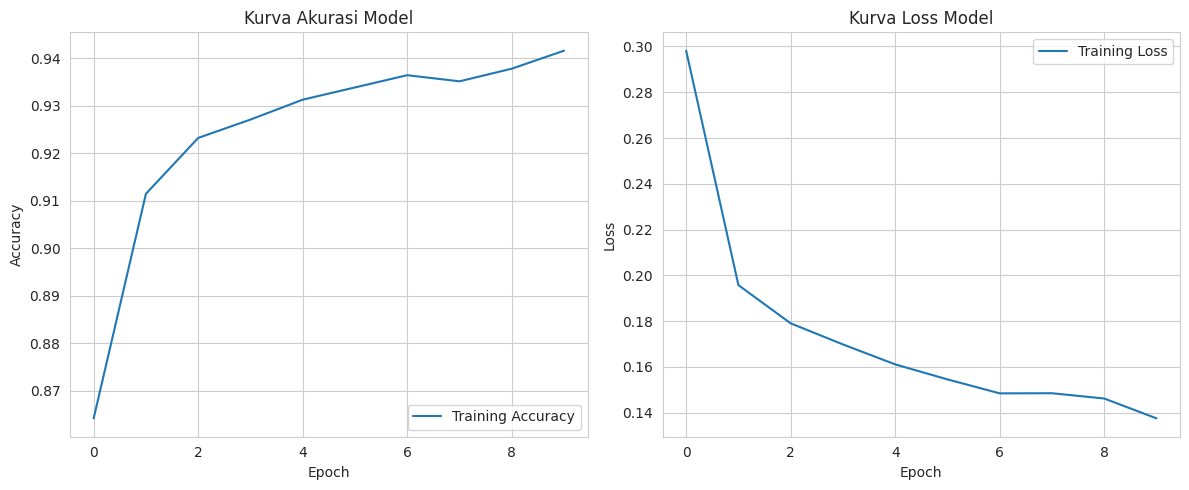

In [11]:
plt.figure(figsize=(12, 5))

# Plot untuk Akurasi
plt.subplot(1, 2, 1) # (1 baris, 2 kolom, plot ke-1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Kurva Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# --- 3. Plot Kurva Loss (Sangat disarankan) ---
# Kuncinya adalah 'loss' (loss data latih) dan 'val_loss' (loss data tes/validasi)

plt.subplot(1, 2, 2) # (1 baris, 2 kolom, plot ke-2)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Kurva Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout() # Agar plot tidak tumpang tindih
plt.show()

# 4. Hyperparameter

In [12]:
import keras_tuner as kt
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
import tensorflow as tf
import pandas as pd

# --- (Asumsi variabel ini sudah ada dari sel sebelumnya) ---
# IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS
# train_generator, test_generator, class_weights
# -------------------------------------------------------------


# --- 1. Buat Fungsi untuk Membangun Model ---
# (Fungsi ini SAMA PERSIS seperti yang Anda berikan, tidak diubah)
def build_model(hp):
    # Muat model dasar Xception
    base_model = Xception(weights='imagenet', include_top=False,
                          input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    base_model.trainable = False

    # Tambahkan lapisan kustom
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # --- Hyperparameter 1: Jumlah Units di Dense Layer ---
    hp_units = hp.Choice('units', values=[256, 512, 1024])
    x = Dense(units=hp_units, activation='relu')(x)

    # --- Hyperparameter 2: Dropout Rate ---
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(rate=hp_dropout)(x)

    # Lapisan output (tetap 12 kelas)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # --- Hyperparameter 3: Pilihan Optimizer ---
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd', 'nadam'])

    # --- Hyperparameter 4: Learning Rate (Tergantung pada Optimizer) ---
    if hp_optimizer == 'adam':
        hp_learning_rate = hp.Choice('lr_adam', values=[1e-3, 5e-4, 1e-4])
        optimizer = Adam(learning_rate=hp_learning_rate)
        
    elif hp_optimizer == 'rmsprop':
        hp_learning_rate = hp.Choice('lr_rmsprop', values=[1e-3, 5e-4, 1e-4])
        optimizer = RMSprop(learning_rate=hp_learning_rate)
        
    elif hp_optimizer == 'sgd':
        hp_learning_rate = hp.Choice('lr_sgd', values=[1e-2, 5e-3, 1e-3])
        optimizer = SGD(learning_rate=hp_learning_rate, momentum=0.9)
        
    else: # Ini akan 'nadam'
        hp_learning_rate = hp.Choice('lr_nadam', values=[1e-3, 5e-4, 1e-4])
        optimizer = Nadam(learning_rate=hp_learning_rate)

    # Compile model dengan optimizer dinamis dan loss function Anda
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy']) # 'accuracy' di sini tidak apa-apa
    
    return model

# --- 2. Inisialisasi Tuner ---
tuner = kt.RandomSearch(
    build_model,
    objective='accuracy', 
    max_trials=5,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='garbage_xception_tuning'
)

# --- PERUBAHAN 2 ---
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# --- 3. Jalankan Pencarian (Menggantikan model.fit()) ---
print("\nMemulai Hyperparameter Tuning...")

tuner.search(
    train_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[stop_early]
)

print("\n✅ Tuning Selesai!")

# --- 4. TAMPILKAN HASIL DAN SIMPAN KE CSV ---

print("\n--- Ringkasan Hasil Hyperparameter Tuning ---")

# Kumpulkan semua hasil dari semua trial
results = []
for trial in tuner.oracle.trials.values():
    if trial.status == 'COMPLETED':
        hps = trial.hyperparameters.values.copy()
        
        # --- PERUBAHAN 4 ---
        score = trial.metrics.get_best_value('accuracy') 
        
        # Dapatkan optimizer & learning rate yang benar
        optimizer = hps.get('optimizer')
        lr = None
        if optimizer == 'adam':
            lr = hps.get('lr_adam')
        elif optimizer == 'rmsprop':
            lr = hps.get('lr_rmsprop')
        elif optimizer == 'sgd':
            lr = hps.get('lr_sgd')
        elif optimizer == 'nadam':
            lr = hps.get('lr_nadam')
            
        # Buat satu baris data
        row = {
            'optimizer': optimizer,
            'learning_rate': lr,
            'units': hps.get('units'),
            'dropout': round(hps.get('dropout'), 2), # Bulatkan dropout
            'accuracy': score # Ganti nama kolom
        }
        results.append(row)

# Buat DataFrame Pandas untuk tampilan tabel yang rapi
results_df = pd.DataFrame(results)

# Urutkan semua hasil berdasarkan akurasi (terbaik di atas)
results_df = results_df.sort_values(by='accuracy', ascending=False)


# --- TAMBAHAN: SIMPAN KE CSV (PERMINTAAN ANDA) ---
nama_file_csv = 'hasil_tuning_hyperparameter.csv'
results_df.to_csv(nama_file_csv, index=False, float_format="%.6f")
print(f"\n✅ Hasil tuning telah disimpan ke file: {nama_file_csv}")
# ----------------------------------------------------


# Tampilkan tabel terpisah untuk SETIAP optimizer
all_optimizers = ['adam', 'rmsprop', 'sgd', 'nadam']

for opt_name in all_optimizers:
    print(f"\n=== Hasil Hyperparameter Terbaik (Hanya {opt_name}) ===")
    
    # Filter DataFrame untuk optimizer ini
    opt_df = results_df[results_df['optimizer'] == opt_name]
    
    if opt_df.empty:
        print(f"Tidak ada trial yang selesai untuk optimizer {opt_name}.")
    else:
        # Tampilkan tabel yang sudah difilter
        # Kita atur urutan kolomnya
        # (Catatan: 'batch_size' tidak ada di sini karena tidak Anda jadikan hyperparameter di build_model)
        cols_to_show = ['learning_rate', 'units', 'dropout', 'optimizer', 'accuracy']
        
        # Tampilkan tanpa nomor index, dan format angka float
        print(opt_df[cols_to_show].to_string(index=False, float_format="%.6f"))

# --- 5. Tampilkan Hasil Terbaik (Keseluruhan) ---
print("\n--- Model Terbaik (Keseluruhan) ---")

# Dapatkan hyperparameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Jumlah Units Terbaik: {best_hps.get('units')}")
print(f"Dropout Rate Terbaik: {round(best_hps.get('dropout'), 2)}") # Dibulatkan

# Ambil learning rate yang benar
optimizer_terbaik = best_hps.get('optimizer')
lr_terbaik = None
if optimizer_terbaik == 'adam':
    lr_terbaik = best_hps.get('lr_adam')
elif optimizer_terbaik == 'rmsprop':
    lr_terbaik = best_hps.get('lr_rmsprop')
elif optimizer_terbaik == 'sgd':
    lr_terbaik = best_hps.get('lr_sgd')
elif optimizer_terbaik == 'nadam':
    lr_terbaik = best_hps.get('lr_nadam')
    
print(f"Optimizer Terbaik: {optimizer_terbaik}")
print(f"Learning Rate Terbaik: {lr_terbaik}")

# Dapatkan model terbaik (sudah dilatih)
best_model = tuner.get_best_models(num_models=1)[0]

# Tampilkan ringkasan model terbaik
print("\nRingkasan Model Terbaik:")
best_model.summary()

Trial 5 Complete [00h 09m 13s]
accuracy: 0.9575411081314087

Best accuracy So Far: 0.9618917107582092
Total elapsed time: 00h 45m 21s

✅ Tuning Selesai!

--- Ringkasan Hasil Hyperparameter Tuning ---

✅ Hasil tuning telah disimpan ke file: hasil_tuning_hyperparameter.csv

=== Hasil Hyperparameter Terbaik (Hanya adam) ===
 learning_rate  units  dropout optimizer  accuracy
      0.001000   1024 0.400000      adam  0.953835

=== Hasil Hyperparameter Terbaik (Hanya rmsprop) ===
 learning_rate  units  dropout optimizer  accuracy
      0.000500    512 0.200000   rmsprop  0.961892
      0.001000    256 0.400000   rmsprop  0.958750

=== Hasil Hyperparameter Terbaik (Hanya sgd) ===
 learning_rate  units  dropout optimizer  accuracy
      0.010000    512 0.200000       sgd  0.955285

=== Hasil Hyperparameter Terbaik (Hanya nadam) ===
 learning_rate  units  dropout optimizer  accuracy
      0.001000    256 0.300000     nadam  0.957541

--- Model Terbaik (Keseluruhan) ---
Jumlah Units Terbaik: 512

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 21,911,081 (83.58 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

# 5. K-Fold Cross Validation

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
import keras_tuner as kt
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- 1. Variabel Kunci ---
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
NUM_CLASSES = 2  # Pastikan ini jumlah kelas Anda
K_FOLDS = 5
EPOCHS_PER_FOLD = 10
BATCH_SIZE = 32


# --- 2. Fungsi Build Model (DIAMBIL DARI SKRIP TUNING ANDA) ---
def build_model(hp):
    # Muat model dasar Xception
    base_model = Xception(weights='imagenet', include_top=False,
                          input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Gunakan hyperparameter dari tuner
    hp_units = hp.Choice('units', values=[256, 512, 1024])
    x = Dense(units=hp_units, activation='relu')(x)
    
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(rate=hp_dropout)(x)
    
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd', 'nadam'])
    
    if hp_optimizer == 'adam':
        hp_learning_rate = hp.Choice('lr_adam', values=[1e-3, 5e-4, 1e-4])
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        hp_learning_rate = hp.Choice('lr_rmsprop', values=[1e-3, 5e-4, 1e-4])
        optimizer = RMSprop(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        hp_learning_rate = hp.Choice('lr_sgd', values=[1e-2, 5e-3, 1e-3])
        optimizer = SGD(learning_rate=hp_learning_rate, momentum=0.9)
    else: # Ini akan 'nadam'
        hp_learning_rate = hp.Choice('lr_nadam', values=[1e-3, 5e-4, 1e-4])
        optimizer = Nadam(learning_rate=hp_learning_rate)
        
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model


# --- 3. Inisialisasi Tuner (SESUAI DENGAN SKRIP TUNING) ---
tuner = kt.RandomSearch(
    build_model,
    objective='accuracy', # <- Ini sudah benar, menggunakan 'accuracy'
    max_trials=5,
    directory='keras_tuner_dir',
    project_name='garbage_xception_tuning'
)


# --- 4. (BARU) Siapkan Data dari Folder (EDISI 80/20) ---
def load_data_from_folders(folder_list, image_width, image_height):
    images = []
    labels = []
    
    base_dir = folder_list[0]
    try:
        class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    except FileNotFoundError:
        print(f"Error: Direktori dasar {base_dir} tidak ditemukan.")
        return None, None
        
    class_map = {class_name: i for i, class_name in enumerate(class_names)}
    
    if not class_map:
        print(f"Error: Tidak ada subdirektori kelas yang ditemukan di {base_dir}")
        return None, None
            
    print(f"Mapping Kelas: {class_map}")

    for folder in folder_list:
        if not os.path.isdir(folder):
            print(f"Peringatan: Folder {folder} tidak ditemukan, dilewati.")
            continue
            
        print(f"Memuat data dari: {folder}...")
        for class_name in class_names:
            class_dir = os.path.join(folder, class_name)
            if not os.path.isdir(class_dir):
                continue
                
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    img = load_img(img_path, target_size=(image_width, image_height))
                    img_array = img_to_array(img)
                    
                    images.append(img_array)
                    labels.append(class_map[class_name])
                except Exception as e:
                    print(f"Gagal memuat {img_path}: {e}")
                    
    if not images:
        print("Error: Tidak ada gambar yang berhasil dimuat.")
        return None, None
        
    images_np = np.array(images)
    labels_np = np.array(labels)
    
    images_np = images_np / 255.0
    
    return images_np, labels_np

# Tentukan path ke SEMUA folder data Anda
base_path = '/kaggle/working'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

# GABUNGKAN SEMUA DATA
print("Memuat SEMUA data (train, validation, test) untuk digabung...")
X_all, y_all = load_data_from_folders(
    [train_dir, test_dir], # Sesuaikan daftar ini
    IMAGE_WIDTH, 
    IMAGE_HEIGHT
)

if X_all is None:
    print("Gagal memuat data. Menghentikan skrip.")
    exit()

print(f"\nTotal data yang dimuat: {len(X_all)} sampel")

# BAGI DATA menjadi 80% (K-Fold) dan 20% (Tes Final)
print("Membagi data menjadi 80% Train (K-Fold) dan 20% Test (Final)...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.20, # 20% untuk data test
    random_state=42,
    stratify=y_all
)

print(f"\nData Train (K-Fold) (80%) dimuat: {len(X_train_val)} sampel")
print(f"Data Test (Final) (20%) dimuat: {len(X_test)} sampel")
print(f"Bentuk X_train_val: {X_train_val.shape}")
print(f"Bentuk X_test: {X_test.shape}")
# ----------------------------------------------


# --- 5. Dapatkan Hyperparameter Terbaik ---
print("\nMemuat hyperparameter terbaik dari tuning sebelumnya...")
try:
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    print("Hyperparameter terbaik ditemukan:")
    optimizer_terbaik = best_hps.get('optimizer')
    print(f"  > Optimizer: {optimizer_terbaik}")
    
    lr_terbaik = None
    if optimizer_terbaik == 'adam':
        lr_terbaik = best_hps.get('lr_adam')
    elif optimizer_terbaik == 'rmsprop':
        lr_terbaik = best_hps.get('lr_rmsprop')
    elif optimizer_terbaik == 'sgd':
        lr_terbaik = best_hps.get('lr_sgd')
    elif optimizer_terbaik == 'nadam':
        lr_terbaik = best_hps.get('lr_nadam')
        
    print(f"  > Learning Rate: {lr_terbaik}")
    print(f"  > Units: {best_hps.get('units')}")
    print(f"  > Dropout: {round(best_hps.get('dropout'), 2)}")
    
except Exception as e:
    print(f"Error: Tidak bisa menemukan hasil tuning. ({e})")
    print("Pastikan nama 'directory' dan 'project_name' di Bagian 3 sudah benar.")
    print("Pastikan Anda sudah menjalankan skrip tuning setidaknya satu kali.")
    exit()


# --- 6. Inisialisasi K-Fold & Variabel Juara ---
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Variabel untuk melacak fold mana yang menang
global_best_acc = 0.0
global_best_loss = 0.0
global_best_fold_index = 0
nama_file_model_juara = 'model_terbaik_dari_kfold.h5'

print(f"\nMemulai {K_FOLDS}-Fold Cross-Validation (Mode: Mencari Model Terbaik)...")


# --- 7. Jalankan Loop K-Fold ---
for fold, (train_index, val_index) in enumerate(kf.split(X_train_val, y_train_val)):
    fold_num = fold + 1
    print("-" * 50)
    print(f"--- FOLD {fold_num}/{K_FOLDS} ---")
    
    X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
    y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
    
    # Build model baru dari hyperparameter terbaik (Section 5)
    model = tuner.hypermodel.build(best_hps)
    
    print(f"Melatih fold {fold_num}...")
    history = model.fit(
        X_train_fold, 
        y_train_fold,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS_PER_FOLD,
        validation_data=(X_val_fold, y_val_fold),
        verbose=1 
    )
    
    # Evaluasi pada data validasi fold ini
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    current_loss = scores[0]
    current_acc = scores[1]
    
    print(f"Skor Fold {fold_num}: Akurasi={current_acc:.4f} | Loss={current_loss:.4f}")
    
    # --- LOGIKA PENENTUAN JUARA ---
    # Jika akurasi fold ini lebih tinggi dari rekor sebelumnya, simpan!
    if current_acc > global_best_acc:
        print(f" >> 🏆 REKOR BARU! ({current_acc:.4f} > {global_best_acc:.4f})")
        print(f" >> Menyimpan model Fold {fold_num} ke file '{nama_file_model_juara}'...")
        
        global_best_acc = current_acc
        global_best_loss = current_loss
        global_best_fold_index = fold_num
        
        # Simpan fisik model (overwrite model lama)
        model.save(nama_file_model_juara)
    else:
        print(f" >> Belum mengalahkan rekor terbaik ({global_best_acc:.4f}). Model tidak disimpan.")
    
    # Bersihkan memori sebelum lanjut ke fold berikutnya
    tf.keras.backend.clear_session()


# --- 8. Tampilkan Hasil Terbaik (Bukan Rata-rata) ---
print("\n" + "=" * 50)
print(f"HASIL PENCARIAN K-FOLD TERBAIK")
print("=" * 50)
if global_best_fold_index == 0:
    print("❌ Error: Tidak ada model yang tersimpan. Cek proses training.")
    exit()
else:
    print(f"Juara Ditemukan pada : Fold {global_best_fold_index}")
    print(f"Akurasi Validasi     : {global_best_acc:.4f}")
    print(f"Loss Validasi        : {global_best_loss:.4f}")
    print(f"Model tersimpan di   : {nama_file_model_juara}")


# --- 9. Evaluasi Model Juara pada Data Test 20% ---
# Kita TIDAK melatih ulang (fit). Kita memuat model juara yang sudah disimpan tadi.
print("\n" + "-" * 50)
print(f"EVALUASI AKHIR PADA DATA TEST (20%)")
print(f"Menggunakan model dari Fold {global_best_fold_index}...")
print("-" * 50)

# Muat model terbaik
final_model = tf.keras.models.load_model(nama_file_model_juara)

# Uji ke data test
test_scores = final_model.evaluate(X_test, y_test, verbose=1)

print("\n" + "#" * 50)
print(">>> HASIL AKHIR SKRIPSI (DATA TEST)")
print(f"Akurasi Test: {test_scores[1]:.4f}")
print(f"Loss Test   : {test_scores[0]:.4f}")
print("#" * 50)


# --- 10. Simpan Laporan Hasil ---
nama_file_hasil = 'hasil_terbaik_final.txt'
print(f"\nMenyimpan laporan ke file: {nama_file_hasil}")

with open(nama_file_hasil, 'w') as f:
    f.write("="*50 + "\n")
    f.write("LAPORAN HASIL MODEL TERBAIK (BEST FOLD STRATEGY)\n")
    f.write("="*50 + "\n\n")
    f.write(f"Model Terbaik Berasal dari : Fold {global_best_fold_index}\n")
    f.write(f"Akurasi Validasi Internal  : {global_best_acc:.4f}\n")
    f.write(f"Loss Validasi Internal     : {global_best_loss:.4f}\n\n")
    f.write("-" * 30 + "\n")
    f.write(f"HASIL PENGUJIAN AKHIR (DATA TEST 20%):\n")
    f.write(f"Akurasi Test : {test_scores[1]:.4f}\n")
    f.write(f"Loss Test    : {test_scores[0]:.4f}\n")
    f.write("-" * 30 + "\n\n")
    f.write("Hyperparameter Terbaik:\n")
    f.write(str(best_hps.values))

print("✅ Selesai! Semua proses tuntas.")

Reloading Tuner from keras_tuner_dir/garbage_xception_tuning/tuner0.json
Memuat SEMUA data (train, validation, test) untuk digabung...
Mapping Kelas: {'anorganik': 0, 'organik': 1}
Memuat data dari: /kaggle/working/train...
Memuat data dari: /kaggle/working/test...

Total data yang dimuat: 15515 sampel
Membagi data menjadi 80% Train (K-Fold) dan 20% Test (Final)...

Data Train (K-Fold) (80%) dimuat: 12412 sampel
Data Test (Final) (20%) dimuat: 3103 sampel
Bentuk X_train_val: (12412, 128, 128, 3)
Bentuk X_test: (3103, 128, 128, 3)

Memuat hyperparameter terbaik dari tuning sebelumnya...
Hyperparameter terbaik ditemukan:
  > Optimizer: rmsprop
  > Learning Rate: 0.0005
  > Units: 512
  > Dropout: 0.2

Memulai 5-Fold Cross-Validation (Mode: Mencari Model Terbaik)...
--------------------------------------------------
--- FOLD 1/5 ---
Melatih fold 1...
Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9243 - loss: 0.1987 - val_accuracy: 0.9625 - val_loss: 0.1015
Epoch 2/10

# 6. Model Prediktif

In [14]:
# --- 10. (BARU) Menjalankan Prediksi Rinci ---
print("\n" + "*"*50)
print(f"Memulai prediksi rinci pada {len(X_test)} gambar test...")

# 1. Jalankan prediksi
# Output adalah probabilitas kelas positif (1), bentuk (N, 1)
predictions_probabilities = final_model.predict(
    X_test,
    batch_size=BATCH_SIZE
)

# Probabilitas adalah array 2D, kita ambil 1D (hanya kolom pertama)
# Contoh: [[0.98], [0.03], ...] -> [0.98, 0.03, ...]
predictions_probabilities_flat = predictions_probabilities.ravel() 

print(f"Bentuk array probabilitas (flat): {predictions_probabilities_flat.shape}")


# 2. Ubah probabilitas menjadi label kelas biner (0 atau 1)
# Threshold 0.5: Jika probabilitas > 0.5 -> Kelas 1; Jika <= 0.5 -> Kelas 0
predicted_classes = (predictions_probabilities_flat > 0.5).astype(int)

print(f"\nHasil prediksi (kelas) untuk 10 gambar pertama:\n {predicted_classes[:10]}")

# 3. Bandingkan dengan label asli
# Untuk perbandingan, kita pastikan y_test (yang mungkin berbentuk (N, 1)) di-flatten
y_test_flat = y_test.ravel()

print(f"\nLabel asli (ground truth) untuk 10 gambar pertama:\n {y_test_flat[:10]}")


# --- 11. (OPSIONAL) Laporan Klasifikasi & Confusion Matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np # Pastikan numpy diimpor (biasanya sudah ada di Bagian 1)

# ⚠️ PENTING: Anda harus mendefinisikan 'class_names' ini secara manual
# Urutannya HARUS SESUAI dengan 'Mapping Kelas' yang dicetak di Bagian 4
# Contoh:
class_names = [
    'anorganik', 'organik' # Ganti ini dengan nama kelas Anda (misal: 'anorganik', 'organik')
]

if len(class_names) == 2: # Untuk biner, pastikan ada 2 nama
    print("\n" + "="*50)
    print("--- Laporan Klasifikasi Rinci ---")
    
    # 1. Classification Report
    print(classification_report(y_test_flat, predicted_classes, target_names=class_names))
    
    # 2. Confusion Matrix
    cm = confusion_matrix(y_test_flat, predicted_classes)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    print("\n--- Confusion Matrix ---")
    print(cm_df)

else:
    print("\nPERINGATAN: 'class_names' harus memiliki 2 elemen untuk klasifikasi biner.")
    print("Laporan rinci dilewati.")


**************************************************
Memulai prediksi rinci pada 3103 gambar test...
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step
Bentuk array probabilitas (flat): (3103,)

Hasil prediksi (kelas) untuk 10 gambar pertama:
 [0 0 0 1 0 0 0 0 0 0]

Label asli (ground truth) untuk 10 gambar pertama:
 [0 0 0 1 0 0 0 0 0 0]

--- Laporan Klasifikasi Rinci ---
              precision    recall  f1-score   support

   anorganik       0.97      0.98      0.98      2518
     organik       0.92      0.89      0.91       585

    accuracy                           0.96      3103
   macro avg       0.95      0.94      0.94      3103
weighted avg       0.96      0.96      0.96      3103


--- Confusion Matrix ---
           anorganik  organik
anorganik       2474       44
organik           65      520


# 7. Evaluasi

Memulai evaluasi rinci pada 3103 gambar test...
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Prediksi selesai.
Contoh Prediksi: [0 0 0 1 0 0 0 0 0 0]
Contoh Asli      : [0 0 0 1 0 0 0 0 0 0]

--- LAPORAN KLASIFIKASI (PER KELAS) ---
              precision    recall  f1-score   support

   anorganik       0.97      0.98      0.98      2518
     organik       0.92      0.89      0.91       585

    accuracy                           0.96      3103
   macro avg       0.95      0.94      0.94      3103
weighted avg       0.96      0.96      0.96      3103


--- CONFUSION MATRIX ---

Heatmap Confusion Matrix telah disimpan ke 'confusion_matrix.png'


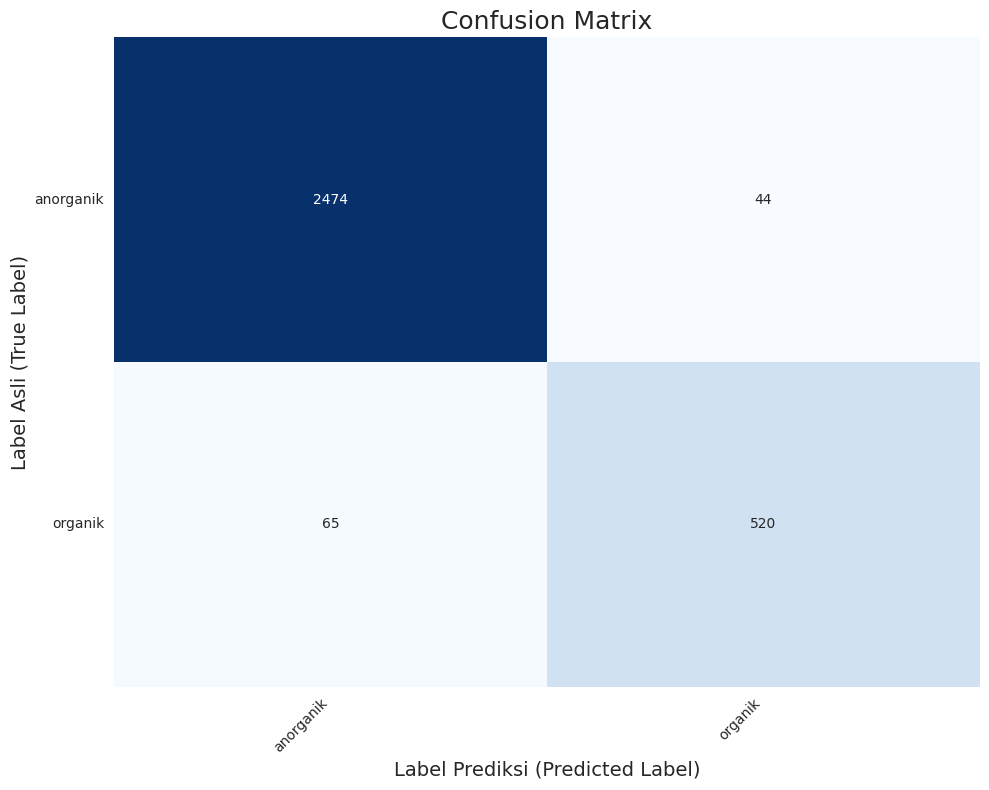

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Ambil Variabel dari Skrip K-Fold ---
# Pastikan skrip K-Fold Anda sudah berjalan dan variabel
# 'final_model', 'X_test', 'y_test', dan 'BATCH_SIZE' sudah ada.

print(f"Memulai evaluasi rinci pada {len(X_test)} gambar test...")

# --- 2. Dapatkan Prediksi (BINER) ---
# 'final_model' adalah model BINER (output Dense(1, sigmoid))
predictions_probabilities = final_model.predict(
    X_test,
    batch_size=BATCH_SIZE
)

# 2a. Flatten probabilitas (dari (N, 1) menjadi (N,))
predictions_probabilities_flat = predictions_probabilities.ravel()

# 2b. Ubah probabilitas menjadi label kelas BINER (0 atau 1)
# Gunakan threshold 0.5: P > 0.5 -> Kelas 1; P <= 0.5 -> Kelas 0
predicted_classes = (predictions_probabilities_flat > 0.5).astype(int)

# 2c. Pastikan label asli (y_test) di-flatten (dari (N, 1) menjadi (N,))
# Agar kompatibel dengan sklearn.metrics
true_classes = y_test.ravel() # Menggunakan .ravel() untuk memastikan bentuk (N,)

print(f"Prediksi selesai.")
print(f"Contoh Prediksi: {predicted_classes[:10]}")
print(f"Contoh Asli      : {true_classes[:10]}")


# --- 3. Definisikan Nama Kelas ---
# ⚠️ PENTING: Urutan HARUS sesuai dengan pemetaan kelas (Kelas 0, Kelas 1).
NUM_CLASSES = 2 # Diambil dari pengaturan biner

class_names = [
    'anorganik', 'organik'
]

if len(class_names) != NUM_CLASSES:
    print("\n--- Peringatan ---")
    print(f"Error: Jumlah 'class_names' ({len(class_names)}) tidak sama dengan 2 (Klasifikasi Biner).")
    print("Pastikan Anda mengisi 'class_names' dengan benar.")
else:

    # --- 4. Tampilkan Laporan Klasifikasi ---
    print("\n" + "="*60)
    print("--- LAPORAN KLASIFIKASI (PER KELAS) ---")
    print("="*60)
    # Menghitung presisi, recall, f1-score untuk setiap kelas
    report = classification_report(true_classes, predicted_classes, target_names=class_names)
    print(report)


    # --- 5. Buat dan Tampilkan Confusion Matrix ---
    print("\n" + "="*60)
    print("--- CONFUSION MATRIX ---")
    print("="*60)
    
    # Buat confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    # Ubah menjadi DataFrame agar mudah dibaca
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Buat heatmap visual 

# [Image of a Confusion Matrix Heatmap]

    plt.figure(figsize=(10, 8)) # Ukuran disesuaikan untuk 2 kelas
    sns.heatmap(
        cm_df, 
        annot=True,     # Tampilkan angka di dalam kotak
        fmt='g',        # Format angka (bukan notasi ilmiah)
        cmap='Blues',   # Skema warna
        cbar=False      # Tidak perlu color bar untuk 2x2
    )
    plt.title('Confusion Matrix', fontsize=18)
    plt.ylabel('Label Asli (True Label)', fontsize=14)
    plt.xlabel('Label Prediksi (Predicted Label)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout() # Merapikan layout
    
    # Simpan gambar
    plt.savefig('confusion_matrix.png')
    print("\nHeatmap Confusion Matrix telah disimpan ke 'confusion_matrix.png'")

# 8. Kurva AUC dan ROC

Memulai perhitungan ROC/AUC Biner...
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step

✅ ROC AUC Score Biner: 0.9913
Ini adalah metrik tunggal untuk keseluruhan model biner.
Membuat plot ROC...


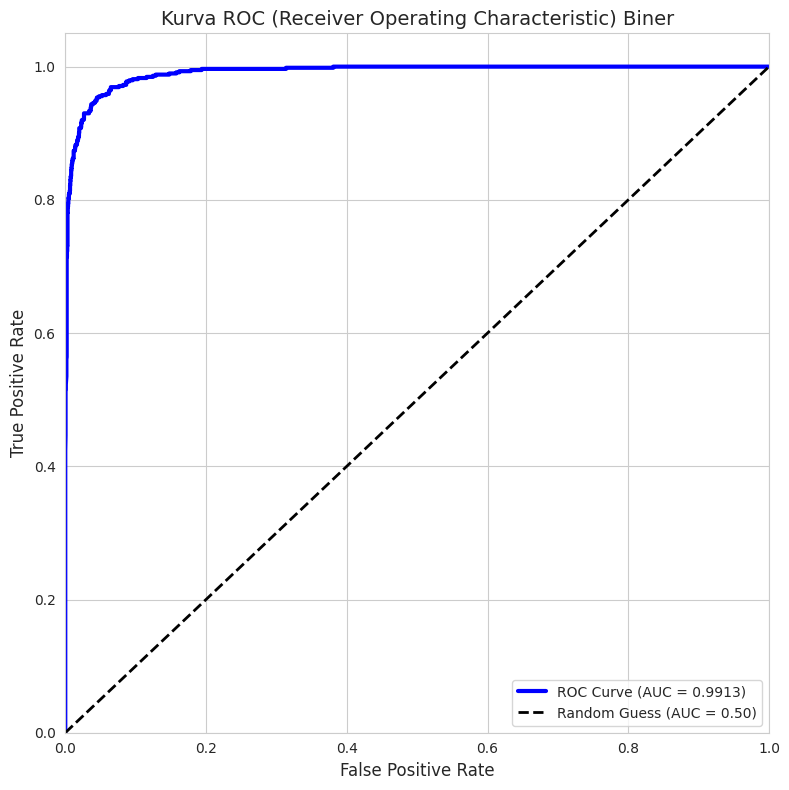


✅ Plot ROC/AUC berhasil disimpan sebagai 'roc_auc_curve_biner.png'


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical # Tidak digunakan, tapi biarkan saja

# --- 1. Persiapan Variabel ---

# Asumsi variabel ini sudah ada dari skrip K-Fold Anda:
# final_model, X_test, y_test, NUM_CLASSES (seharusnya 2), class_names
# Catatan: Kita hanya perlu dua nama kelas (misal: ['anorganik', 'organik'])

print("Memulai perhitungan ROC/AUC Biner...")

# --- 2. Dapatkan Probabilitas Prediksi ---
# Output y_pred_proba memiliki bentuk (N, 1) [Probabilitas Kelas 1]
y_pred_proba = final_model.predict(X_test)

# --- 3. Flatten Data untuk Sklearn ROC Biner ---
# Sklearn roc_curve untuk biner membutuhkan input 1D (N,)
y_pred_proba_flat = y_pred_proba.ravel()
y_test_flat = y_test.ravel() # Mengubah label asli (0 atau 1) menjadi 1D

# --- 4. Hitung ROC dan AUC Biner ---
# Membandingkan label biner (y_test_flat) dengan probabilitas kelas positif (y_pred_proba_flat)
fpr_biner, tpr_biner, thresholds = roc_curve(y_test_flat, y_pred_proba_flat)
roc_auc_biner = auc(fpr_biner, tpr_biner)

print(f"\n✅ ROC AUC Score Biner: {roc_auc_biner:.4f}")
print("Ini adalah metrik tunggal untuk keseluruhan model biner.")

# --- 5. Plot Kurva ROC Biner ---
print("Membuat plot ROC...")
plt.figure(figsize=(8, 8))

# Plot kurva ROC Biner
plt.plot(fpr_biner, tpr_biner,
         label=f'ROC Curve (AUC = {roc_auc_biner:.4f})',
         color='blue', linewidth=3)

# Plot garis acak (no-skill)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess (AUC = 0.50)')

# Pengaturan plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Kurva ROC (Receiver Operating Characteristic) Biner', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()

# Simpan dan tampilkan
plt.savefig('roc_auc_curve_biner.png')
# 

# [Image of a typical ROC curve plot]

plt.show()

print("\n✅ Plot ROC/AUC berhasil disimpan sebagai 'roc_auc_curve_biner.png'")

# 9. Visualisasi Error Analysis

Found 3103 images belonging to 2 classes.
Melakukan prediksi...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step
Jumlah total gambar salah prediksi: 585


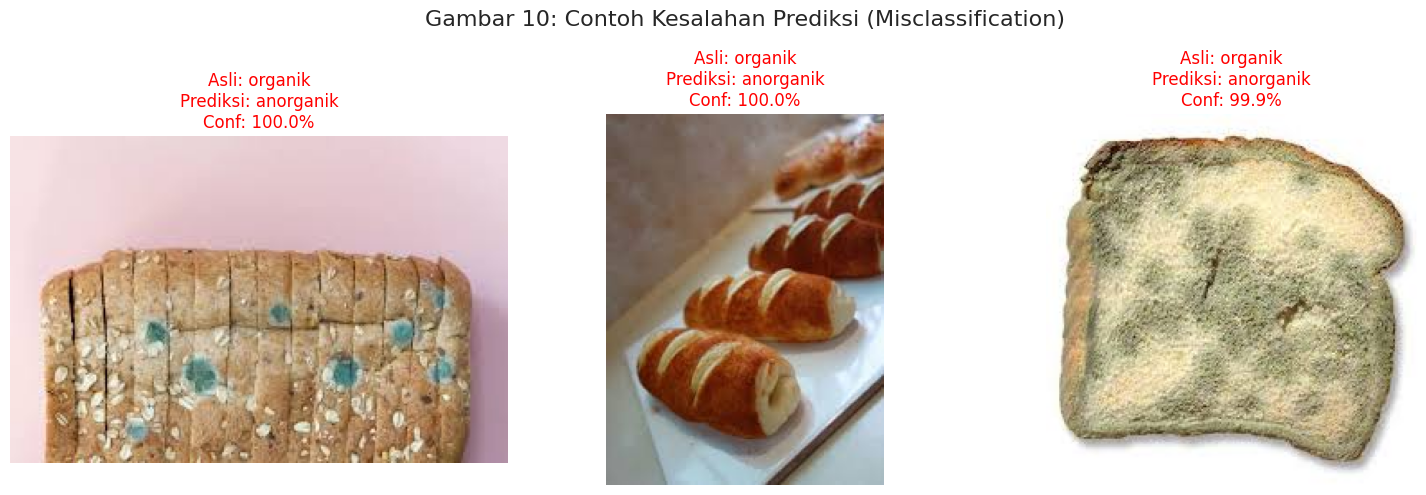

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# 1. Load Model Terbaik Anda (Ganti nama file sesuai model Anda)
# misal: model = load_model('best_model_mobilenet.h5')
model = load_model('/kaggle/working/model_terbaik_dari_kfold.h5')

# 2. Siapkan Data Test (PENTING: shuffle=False agar urutan tidak acak)
test_dir = '/kaggle/working/test' # Ganti dengan path folder test Anda
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128), # Sesuaikan dengan input size model (misal 224 atau 299)
    batch_size=32,
    class_mode='binary',
    shuffle=False # WAJIB FALSE untuk mapping error analysis
)

# 3. Lakukan Prediksi
print("Melakukan prediksi...")
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 4. Cari Indeks Gambar yang Salah Prediksi
errors = np.where(predicted_classes != true_classes)[0]
print(f"Jumlah total gambar salah prediksi: {len(errors)}")

# 5. Visualisasi 3 Gambar Salah (Untuk Bukti Gambar 10)
# Kita ambil 3 error pertama (atau bisa diacak)
import random
selected_errors = errors[:3] if len(errors) >= 3 else errors # Ambil 3 error pertama

plt.figure(figsize=(15, 5))

for i, error_idx in enumerate(selected_errors):
    # Ambil path file gambar
    filepath = test_generator.filepaths[error_idx]
    
    # Load gambar
    img = plt.imread(filepath)
    
    # Siapkan Label
    true_label = class_labels[true_classes[error_idx]]
    pred_label = class_labels[predicted_classes[error_idx]]
    conf = np.max(predictions[error_idx]) * 100
    
    # Plot
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"Asli: {true_label}\nPrediksi: {pred_label}\nConf: {conf:.1f}%", color='red')
    plt.axis('off')

plt.suptitle("Gambar 10: Contoh Kesalahan Prediksi (Misclassification)", fontsize=16)
plt.tight_layout()
plt.show()

# 10. Rata-rata Waktu

In [18]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.models import load_model

# --- 1. LOAD MODEL (KHUSUS XCEPTION) ---
print("Sedang memuat model Xception...")

try:
    # Ganti path di bawah ini dengan lokasi file model Xception Anda yang sebenarnya
    # Contoh di Kaggle: '/kaggle/input/nama-dataset-anda/model_terbaik_dari_kfold_xception.h5'
    path_model = 'model_terbaik_dari_kfold.h5' 
    
    best_model_xception = load_model(path_model)
    
    print(f"✅ Model berhasil di-load dari: {path_model}")

except OSError as e:
    print(f"\n❌ ERROR: File model tidak ditemukan!\nPesan Error: {e}")
    print("Saran: Cek panel 'Data' di kanan, klik 'Copy File Path', lalu paste ke variabel 'path_model' di atas.")
    raise

# --- 2. DEFINISI FUNGSI HITUNG WAKTU ---
def calculate_inference_time(model, dataset):
    print(f"\nSedang menguji kecepatan untuk model: {model.name}...")
    times = []
    
    # Ambil 1 batch data dari test_generator
    try:
        images, _ = next(iter(dataset)) 
    except Exception:
        print("⚠️ Error: test_generator belum didefinisikan atau kosong.")
        return 0
    
    # Loop untuk memprediksi setiap gambar satu per satu
    for i in range(len(images)):
        # Siapkan gambar (tambah dimensi batch: (128,128,3) -> (1,128,128,3))
        img = np.expand_dims(images[i], axis=0) 
        
        # Mulai stopwatch
        start_time = time.time()
        
        # Lakukan prediksi (inferensi)
        _ = model.predict(img, verbose=0) 
        
        # Stop stopwatch
        end_time = time.time()
        
        # Simpan selisih waktunya
        times.append(end_time - start_time)
    
    # Hitung rata-rata dan ubah ke milidetik (ms)
    avg_time = (sum(times) / len(times)) * 1000 
    print(f"⏱️ Rata-rata Inference Time {model.name}: {avg_time:.2f} ms per citra")
    return avg_time

# --- 3. EKSEKUSI FUNGSI (FOKUS XCEPTION) ---
print("\n--- HASIL PENGUKURAN INFERENCE TIME ---")

# Pastikan test_generator sudah ada di memori
if 'test_generator' in locals() or 'test_generator' in globals():
    # Jalankan hanya untuk Xception
    waktu_xception = calculate_inference_time(best_model_xception, test_generator)
    
    print("\n--- HASIL AKHIR ---")
    print(f"Model Xception membutuhkan waktu rata-rata: {waktu_xception:.2f} ms/citra")
else:
    print("⚠️ Peringatan: Variabel 'test_generator' tidak ditemukan. Harap jalankan cell persiapan data terlebih dahulu.")

Sedang memuat model Xception...
✅ Model berhasil di-load dari: model_terbaik_dari_kfold.h5

--- HASIL PENGUKURAN INFERENCE TIME ---

Sedang menguji kecepatan untuk model: functional...
⏱️ Rata-rata Inference Time functional: 178.69 ms per citra

--- HASIL AKHIR ---
Model Xception membutuhkan waktu rata-rata: 178.69 ms/citra
